# Einfaches CNN(1)-Netz

- Subsample-Länge nun 150 (ca. jeder 10. Datenpunkt)
- mehrere `Conv1D`-Layer
- `Dense`-Layer zum Zusammenfassen zu einem Skalar
- `Lambda` skaliert Vorhersage um Faktor 2000 (damit kann Vorhersage zwischen 0 und 1 liegen)
- reagiert sehr empfindlich auf learning_rate (kein Lernfortschritt)
- `Conv1D` mit `stride` scheint besser als `MaxPool1D` zu funktionieren

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, metrics, manifold
from tensorflow import keras
import keras_tuner as kt

import prepare

2025-02-27 08:43:44.552102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 08:43:44.552129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 08:43:44.553148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 08:43:44.559849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 08:43:46.924538: I exter

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER
SUBSAMPLE_LEN = 150

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train_valid, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train, versuche_valid = model_selection.train_test_split(versuche_train_valid, test_size=0.1, random_state=42)
versuche_train.shape, versuche_valid.shape, versuche_test.shape

((432, 5), (48, 5), (120, 5))

Subsampling

In [7]:
subsample2 = prepare.Subsample2(SUBSAMPLE_LEN)
subsample2.fit() # dummy

Subsample2(subsample=150)

In [8]:
X_train = subsample2.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))
X_valid = subsample2.transform(versuche_valid.key, kurven)
label_valid = versuche_valid.label.values
festigkeit_valid = versuche_valid.festigkeit.values
print(X_valid.shape, label_valid.shape)
print(X_valid.max(axis=(0,1)))

#festigkeit_train

(432, 150, 3) (432,)
[3625.56   625.019    4.15 ]
(48, 150, 3) (48,)
[3513.08   621.113    4.01 ]


In [9]:
X_test = subsample2.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 150, 3)
[3533.99   626.972    3.84 ]


Skalieren Trainingsdaten

In [10]:
tsMaxScale = prepare.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)
X_valid_scaled = tsMaxScale.transform(X_valid)

Skalieren Testdaten

In [11]:
X_test_scaled = tsMaxScale.transform(X_test)

In [12]:
def class_curves(X, ax, y, field):
    color = ['black', 'blue', 'red', 'green', 'cyan']
    ti = np.arange(0, X.shape[1]) # Zeitschritte
    for i in range(X.shape[0]):
        #print(X[i,:,ax])
        plt.plot(ti, X[i,:,ax], c=color[y[i]], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

Anzeige Kurven zur Kontrolle.

Text(0.5, 1.0, 'Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert')

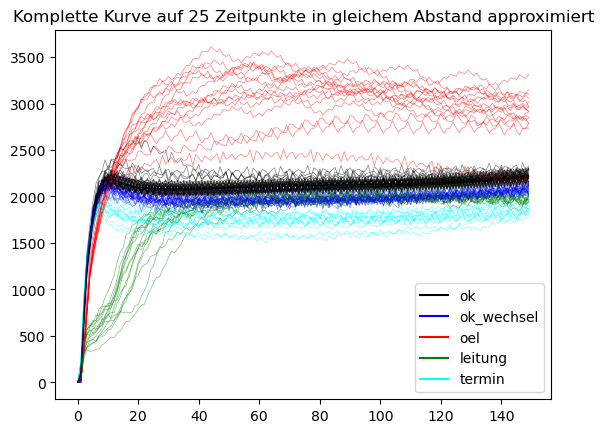

In [13]:
class_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
plt.title("Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert")

Alle Features verwenden

In [14]:
dims = X_train.shape
#X2_train = X_train_scaled.reshape(-1, dims[1]*dims[2])
#X2_test = X_test_scaled.reshape(-1, dims[1]*dims[2])
#X2_train = X_train_scaled[:,:,0]
#X2_valid = X_valid_scaled[:,:,0]
#X2_test = X_test_scaled[:,:,0]
X2_train = X_train_scaled
X2_valid = X_valid_scaled
X2_test = X_test_scaled
X2_train.shape

(432, 150, 3)

Hyperparametersuche



In [15]:
def build_class(hp):
    #n_cnn = hp.Int("n_cnn", min_value=1, max_value=5, default=2)
    n_kernel_size = hp.Int("n_kernel_size", min_value=2, max_value=8, default=5)
    n_pool_size = hp.Int("n_pool_size", min_value=2, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=64, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling='log')
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X2_train.shape[1:]))
    model.add(keras.layers.Conv1D(
        filters=n_neurons, kernel_size=(n_kernel_size,),
        activation='relu',
    ))
    model.add(keras.layers.MaxPool1D(
        pool_size=n_pool_size,
    ))
    model.add(keras.layers.Conv1D(
        filters=n_neurons, kernel_size=(n_kernel_size,),
        activation='relu',
    ))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_neurons, use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.add(keras.layers.Lambda(lambda x: x*2000.0))
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    )
    return model
    

In [16]:
random_search_tuner = kt.RandomSearch(
    build_class, objective='val_loss', max_trials=10,
    overwrite=True, directory='cnn1', project_name='cnn1_reg',
)
#random_search_tuner.search(X2_train, festigkeit_train, epochs=30, batch_size=8,
#    validation_data=(X2_valid, festigkeit_valid)
#)

In [17]:
#model_reg = random_search_tuner.get_best_models(num_models=1)[0]
#hp = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
#hp.values


In [18]:
#model_reg = random_search_tuner.get_best_models(num_models=1)[0]
#model_reg.summary()

Manuelles Modell aus mehreren Hyperparametersuchen

- `stride` funktioniert besser als MaxPool1D?
- reagiert sehr empfindlich auf learning_rate (zufallsabhängig?)

In [19]:
model_reg = keras.models.Sequential()
model_reg.add(keras.layers.Input(shape=X2_train.shape[1:]))
model_reg.add(keras.layers.Conv1D(
    filters=128, kernel_size=(15,),
    activation='relu',
))
#model_reg.add(keras.layers.MaxPool1D(
#    pool_size=4,
#))
model_reg.add(keras.layers.Conv1D(
    filters=128, kernel_size=(8,),
    strides=3,
    activation='relu',
))
#model_reg.add(keras.layers.MaxPool1D(
#    pool_size=2,
#))
model_reg.add(keras.layers.Conv1D(
    filters=128, kernel_size=(4,),
    strides=2,
    activation='relu',
))
model_reg.add(keras.layers.Flatten())
#model_reg.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
model_reg.add(keras.layers.Dense(1, activation='relu', kernel_initializer='he_normal'))
model_reg.add(keras.layers.Lambda(lambda x: x*2000.0))

model_reg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='mse',
)
model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 136, 128)          5888      
                                                                 
 conv1d_3 (Conv1D)           (None, 43, 128)           131200    
                                                                 
 conv1d_4 (Conv1D)           (None, 20, 128)           65664     
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2561      
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 205313 (802.00 KB)
Trainable params: 205

In [20]:
# uncomment to disable gpu
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

hist = model_reg.fit(X2_train, festigkeit_train, epochs=100, batch_size=16,
    validation_data=(X2_valid, festigkeit_valid),
    callbacks=[early_stopping]
)
y_pred_valid = model_reg.predict(X2_valid)
metrics.mean_squared_error(festigkeit_valid, y_pred_valid)


Epoch 1/100


2025-02-27 08:43:59.181771: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-02-27 08:44:00.905402: I external/local_xla/xla/service/service.cc:168] XLA service 0x77a8b8fb7620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 08:44:00.905433: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-02-27 08:44:00.973794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740642241.328152   32115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 [==============================] - 5s 23ms/step - loss: 2672763.2500 - val_loss: 950651.5000
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 978731.5625 - val_loss: 814974.4375
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 831160.1250 - val_loss: 656123.8125
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 722659.1250 - val_loss: 556847.2500
Epoch 5/100
27/27 [==============================] - 0s 4ms/step - loss: 608094.8750 - val_loss: 486227.0938
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 507882.4062 - val_loss: 368567.5938
Epoch 7/100
27/27 [==============================] - 0s 4ms/step - loss: 397317.9375 - val_loss: 297154.1250
Epoch 8/100
27/27 [==============================] - 0s 4ms/step - loss: 306029.6875 - val_loss: 221440.9375
Epoch 9/100
27/27 [==============================] - 0s 4ms/step - loss: 238356.4844 - val_loss: 164600.2812
Epoch 10/100
27/27 [=========

20367.75596170305

<Axes: >

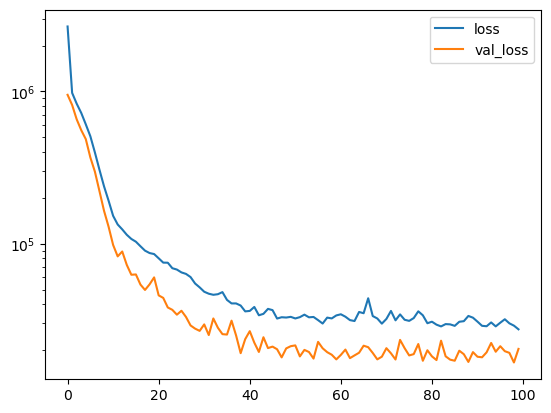

In [21]:
pd.DataFrame(hist.history).plot(logy=True)

Vorhersage Trainingsdaten

14/14 [==============================] - 0s 2ms/step


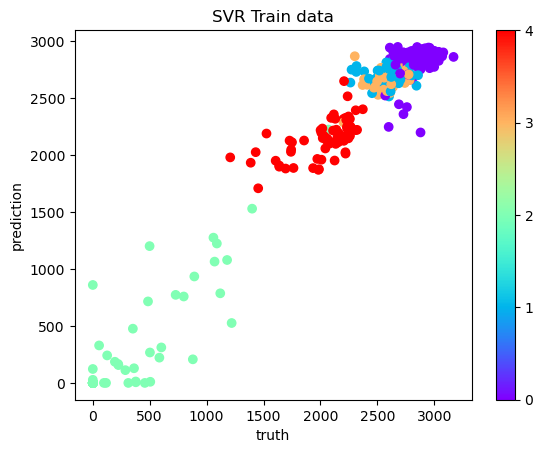

In [22]:
y_pred_train = model_reg.predict(X2_train)#*SCALE_FEST
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('SVR Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('ann1_train.png')

2/2 [==============================] - 0s 3ms/step


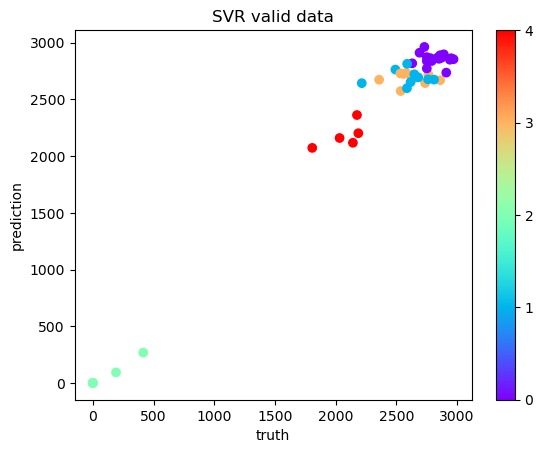

In [23]:
y_pred_valid = model_reg.predict(X2_valid)#*SCALE_FEST
plt.scatter(festigkeit_valid, y_pred_valid, c=label_valid, cmap='rainbow')
plt.title('SVR valid data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('ann1_valid.png')

Vorhersage Testdaten

4/4 [==============================] - 0s 102ms/step


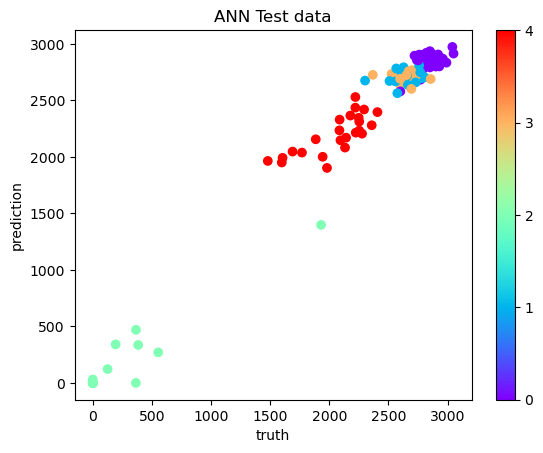

In [24]:
y_pred_test = model_reg.predict(X2_test)#*SCALE_FEST
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
#plt.plot([0, 3000], [0,3000], "k:")
plt.title('ANN Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('ann1_test.png')

In [25]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train  30213.2, test:  21150.2
RMSE: train    173.8 test:    145.4
MAE: train    115.1, test:     99.0
